# CS 342 Final Project - Letter Recognition CNN

#### Mrityunjay Mishra, Mihir Suvarna, Daniel Sialm

## Project Description

This project aims to create a convolutional neural network (CNN) for the task of letter recognition. The task of letter recognition, or more generally speaking, text recognition (also known as optical character recognition, or OCR) has gained much importance in recent years due to emerging applications. For example, OCR software can be used to convert handwritten text into digital text and robots use cameras to read signs in their environment. Due to the increasing importance of the task of text recognition, we aim to create a robust CNN that is able to correctly classify handwritten and digital letters. 

In [1]:
# Standard imports
import torch
from torch import nn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Dataset

In [67]:
from torchvision import datasets, transforms

save_dir = 'letterEMNIST'

transform = transforms.ToTensor() # Convert the image into a torch tensor.

train_set = datasets.EMNIST(save_dir, split="letters", download=True, train=True, transform=transform)
test_set = datasets.EMNIST(save_dir, split="letters", download=True, train=False, transform=transform)

print(train_set)
print(test_set)

Dataset EMNIST
    Number of datapoints: 124800
    Root location: letterEMNIST
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset EMNIST
    Number of datapoints: 20800
    Root location: letterEMNIST
    Split: Test
    StandardTransform
Transform: ToTensor()


In [70]:
from torch.utils.data.sampler import SubsetRandomSampler
ntotal = 60000
ntrain = int(0.9*ntotal)
nval = ntotal - ntrain

val_ix = np.random.choice(range(ntotal), size=nval, replace=False)
train_ix = list(set(range(ntotal)) - set(val_ix))
print(len(train_ix), len(val_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)

54000 6000


In [73]:
# initialize the data sets
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Label: w


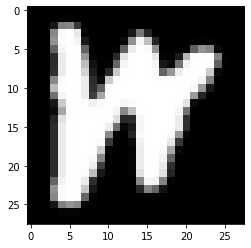

In [27]:
# print classes
print(train_set.classes)
classes = train_set.classes
# print label
index = 0
plt.imshow(train_set.data[index].T, cmap='Greys_r')
print("Label: %s" % train_set.classes[train_set.targets[index]])

## Create the CNN

In [121]:
letter_to_label = dict()
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
l = 1
for letter in letters:
    letter_to_label[letter] = l
    l += 1
print(letter_to_label)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [137]:
# making a dataset of our data
import os
import shutil
import glob

from PIL import Image
import torchvision.transforms as transforms

transform = transforms.ToTensor()

src_dir = 'cropped_images'
imgs = []
labels = []
for f in glob.glob(os.path.join(src_dir, '*.png')):
    ftitle, fext = os.path.splitext(os.path.basename(f))
    letter = ftitle.split("_")[1].lower()
    labels.append( letter_to_label[letter] )
    im = Image.open(f).convert('L')
    imgs.append(transform(im).detach().numpy())
data = torch.tensor(imgs)
labels = np.array(labels)

# labels = []
# for i in range(13):
#     labels.append( [1] * 101 ) # a
#     labels.append( [2] * 101 ) # b
#     labels.append( [3] * 101 ) # c
#     labels.append( [4] * 101 ) # d
#     labels.append( [5] * 101 ) # e
#     labels.append( [6] * 101 ) # f
#     labels.append( [7] * 101 ) # g
#     labels.append( [8] * 101 ) # h
#     labels.append( [9] * 101 ) # i
#     labels.append( [10] * 101 ) # j
#     labels.append( [11] * 101 ) # k
#     labels.append( [12] * 101 ) # l
#     labels.append( [13] * 101 ) # m
#     labels.append( [14] * 101 ) # n
#     labels.append( [15] * 101 ) # o
#     labels.append( [16] * 101 ) # p
#     labels.append( [17] * 101 ) # q
#     labels.append( [18] * 101 ) # r
#     labels.append( [19] * 101 ) # s
#     labels.append( [20] * 101 ) # t
#     labels.append( [21] * 101 ) # u
#     labels.append( [22] * 101 ) # v
#     labels.append( [23] * 101 ) # w
#     labels.append( [24] * 101 ) # x
#     labels.append( [25] * 101 ) # y
#     labels.append( [26] * 101 ) # z

# labels = np.array(labels).flatten()
# labels = torch.tensor(np.array(labels).flatten())

print(data.shape)
print(labels.shape)

# train_dataset = torch.utils.data.TensorDataset(torch.tensor(imgs), torch.tensor(labels))
# data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

torch.Size([34138, 1, 28, 28])
(34138,)


In [138]:
# shuffling the data
indices = torch.randperm(data.shape[0])
data = data[indices]
labels = labels[indices]
labels = torch.tensor(labels)

train_dataset = torch.utils.data.TensorDataset(data[0:23897], labels[0:23897])
val_dataset = torch.utils.data.TensorDataset(data[23897:30724], labels[23897:30724])
test_dataset = torch.utils.data.TensorDataset(data[30724:34138], labels[30724:34138])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)

Label: tensor(13)


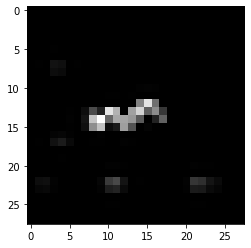

In [139]:
plt.imshow(data[1600].squeeze(), cmap='Greys_r')
print("Label: %s" % labels[1600])

In [140]:
# inputs are 28x28

class letterCNN(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, len(self.classes))
        )
            

    def forward(self, x):
        return self.layers(x)

In [141]:
model = letterCNN(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)

In [142]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=100):
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

def test_network(model, test_loader):
    correct = 0
    total = 0
    true, pred = [], []
    with torch.no_grad():
        for inputs, labels  in test_loader:
            outputs = model(inputs)
            predicted = torch.argmax(outputs, dim=1) # get predicted class label for each test example.
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.append(labels)
            pred.append(predicted)
    acc = (100 * correct / total)
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return acc, true, pred

In [143]:
train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 3.04064
   Val loss: 2.65439

EPOCH 1
 Train loss: 2.31027
   Val loss: 2.03031

EPOCH 2
 Train loss: 1.84759
   Val loss: 1.68168

EPOCH 3
 Train loss: 1.55903
   Val loss: 1.44083

EPOCH 4
 Train loss: 1.34875
   Val loss: 1.25574

EPOCH 5
 Train loss: 1.18011
   Val loss: 1.10114

EPOCH 6
 Train loss: 1.03582
   Val loss: 0.96629

EPOCH 7
 Train loss: 0.90862
   Val loss: 0.84644

EPOCH 8
 Train loss: 0.79489
   Val loss: 0.73880

EPOCH 9
 Train loss: 0.69237
   Val loss: 0.64159



Test accuracy: 89.530


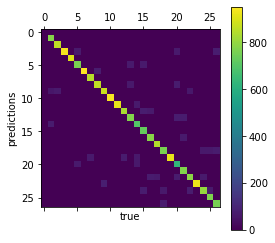

In [144]:
acc, true, pred = test_network(model, test_loader)
print('Test accuracy: %0.3f' % acc)

contingency = np.zeros((len(model.classes), len(model.classes)))
for i in range(len(pred)):
    contingency[int(pred[i])][int(true[i])] += 1

plt.matshow(contingency)
plt.xlabel("true")
plt.ylabel("predictions")
plt.colorbar()

## Visualizing Optimized Inputs

In [17]:
class OptimizeInput(nn.Module):
    def __init__(self, learned_model, input_shape=(1, 1, 28, 28)):
        super().__init__()
        self.learned_model = learned_model
        self.optimized_input = torch.zeros(input_shape, requires_grad=True)
        
    def forward(self):
        return self.learned_model(self.optimized_input)
    
    def parameters(self):
        return [self.optimized_input]

In [24]:
# Train OptimizeInput model, one for each letter
targets = torch.arange(len(model.classes)).long()
optimized_inputs = []

n_epochs = 10000

for t in targets:
    input_model = OptimizeInput(model)
    optimizer = torch.optim.Adam(input_model.parameters(), lr=.0001)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = input_model()
        loss = criterion(outputs, t.reshape(1))
        loss.backward()
        optimizer.step()
    print("finished %s with %0.5f loss" % (model.classes[t], loss.item()))
    optimized_inputs.append(input_model.optimized_input.detach().numpy().reshape((28, 28)))

finished N/A with 3.03184 loss
finished a with 0.00216 loss
finished b with 0.00142 loss
finished c with 0.00112 loss
finished d with 0.00128 loss
finished e with 0.00272 loss
finished f with 0.00080 loss
finished g with 0.00213 loss
finished h with 0.00089 loss
finished i with 0.00159 loss
finished j with 0.00028 loss
finished k with 0.00096 loss
finished l with 0.00040 loss
finished m with 0.00185 loss
finished n with 0.00201 loss
finished o with 0.00407 loss
finished p with 0.00109 loss
finished q with 0.00141 loss
finished r with 0.00184 loss
finished s with 0.00102 loss
finished t with 0.00053 loss
finished u with 0.00170 loss
finished v with 0.00159 loss
finished w with 0.00119 loss
finished x with 0.00165 loss
finished y with 0.00051 loss
finished z with 0.00088 loss


In [25]:
for i in range(len(model.classes)):
    letter = model.classes[i]
    tensor = torch.Tensor(optimized_inputs[i].reshape(1, 1, 28, 28))
    output = model(tensor)
    prob = output.squeeze().detach().numpy()
    pred = model.classes[torch.argmax(output, dim=1)]
    print(f"Expected: {letter}. Predicted: {pred}.")
    
#     plt.figure()
#     plt.bar(range(len(model.classes)), np.exp(prob) / np.exp(prob).sum())
#     plt.xticks(range(len(model.classes)), model.classes)

Expected: N/A. Predicted: j.
Expected: a. Predicted: a.
Expected: b. Predicted: b.
Expected: c. Predicted: c.
Expected: d. Predicted: d.
Expected: e. Predicted: e.
Expected: f. Predicted: f.
Expected: g. Predicted: g.
Expected: h. Predicted: h.
Expected: i. Predicted: i.
Expected: j. Predicted: j.
Expected: k. Predicted: k.
Expected: l. Predicted: l.
Expected: m. Predicted: m.
Expected: n. Predicted: n.
Expected: o. Predicted: o.
Expected: p. Predicted: p.
Expected: q. Predicted: q.
Expected: r. Predicted: r.
Expected: s. Predicted: s.
Expected: t. Predicted: t.
Expected: u. Predicted: u.
Expected: v. Predicted: v.
Expected: w. Predicted: w.
Expected: x. Predicted: x.
Expected: y. Predicted: y.
Expected: z. Predicted: z.


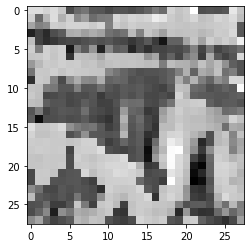

In [42]:
letter = 'j'
letter_visualized = optimized_inputs[model.classes.index(letter)].T
plt.imshow(letter_visualized, cmap='Greys_r')
# letter_visualized = letter_visualized.flatten()
# for i in range(28*28):
#     letter_visualized[i] = 0 if letter_visualized[i] < 0 else 1  
# plt.imshow(letter_visualized.reshape((28,28)), cmap='Greys_r')